## Use full data from Odyssey

In [177]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['power', 'mat', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [178]:
binfile = '/mnt/store1/oliverphilcox/PowerSpectra/k_binning2.csv'
counts_dir = '/mnt/store1/oliverphilcox/PowerQPM_New/R0_50/'
#counts_dir1 = '/mnt/store1/oliverphilcox/PowerQPM50/'
#counts_dir2 = '/mnt/store1/oliverphilcox/PowerQPM50_noPhi/'
n = 19
l = 4
m = l//2+1

### Load in counts

In [179]:
k_bins = np.loadtxt(binfile).mean(axis=1)
all_k = np.loadtxt(binfile)

In [180]:
RR = np.zeros([n,m])
index = 0
while True:
    filename = counts_dir+'RR_%d_power_counts_n%d_m%d_full.txt'%(index,n,m)
    if not os.path.exists(filename):
        break
    RR+=np.loadtxt(filename)
    index+=1

In [181]:
DD = np.loadtxt(counts_dir+'DD_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))
DR = np.loadtxt(counts_dir+'DR_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))

In [182]:
### count number of random particles
rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x.xyzwj'
with open(rand_par) as infile:
    for l,line in enumerate(infile):
        pass
N_rand = l+1

In [183]:
### count number of galaxies
gal_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_galaxy_1.xyzwj'
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        pass
N_gal=l+1

In [184]:
### count number of randoms
index = 0.
RR_pairs = 0.
while True:
    this_rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x_%d'%index
    if not os.path.exists(this_rand_par):
        break
    with open(this_rand_par) as infile:
        for l,line in enumerate(infile):
            pass
    RR_pairs+=(l+1)*l
    index+=1

In [185]:
DR_pairs = N_gal*N_rand
DD_pairs = N_gal*(N_gal-1)

In [186]:
norm = 0
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        this_w = float(line.split()[3])
        norm+=this_w**2.*(1./this_w-1.)/20000
print("Norm = %.2f"%norm)

Norm = 4.25


In [187]:
### compute power
power = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm
#power_noPhi = (DDnoPhi-2.*DRnoPhi/(DR_pairs/DD_pairs)+RRnoPhi/(RR_pairs/DD_pairs))/(norm*N_gal/N_rand)

In [192]:
all_DD=[]
all_DR=[]
good_mocks=[]
n_mocks=0
for mock_int in range(1,101):
    mock_no = str(mock_int).zfill(4)
    if os.path.exists(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
        if os.path.exists(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
            tDD = np.loadtxt(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            tDR = np.loadtxt(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            all_DD.append(tDD)
            all_DR.append(tDR)
            n_mocks+=1
            good_mocks.append(mock_no)

In [196]:
len(good_mocks)

93

In [197]:
### count number of galaxies in each file
N_gal_all=[]
norm_all=[]
for mock_no in good_mocks:
    ### count number of galaxies
    gal_par = '/mnt/store1/oliverphilcox/QPM_proc/qpm_galaxy_%s.xyzw'%mock_no
    this_norm=0.
    with open(gal_par) as infile:
        for l,line in enumerate(infile):
            this_w = float(line.split()[3])
            this_norm+=this_w**2.*(1./this_w-1.)/20000
    N_gal_all.append(l+1)
    norm_all.append(this_norm)

In [198]:
all_power = []
pow_mean,pow_std = [np.zeros([n,m]) for _ in range(2)]
for i in range(n_mocks):
    all_power.append((all_DD[i]-2.*all_DR[i]/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm_all[i])
for i in range(n):
    for j in range(m):
        pow_mean[i,j] = np.mean([all_power[ind][i,j] for ind in range(n_mocks)])
        pow_std[i,j] = np.std([all_power[ind][i,j] for ind in range(n_mocks)])

#### Define Covariance

In [409]:
qpm_cov = np.zeros([len(all_power[0].ravel()),len(all_power[0].ravel())])
power_mean = power_ravel.mean(axis=0)
for i in range(len(good_mocks)):
    tmp = all_power[i].T.ravel().reshape(-1,1)-power_mean.reshape(-1,1)
    qpm_cov+=np.matmul(tmp,tmp.T)
qpm_cov/=len(good_mocks)-1

In [396]:
qpm_std = (np.diag(qpm_cov)**0.5).reshape(m,n).T

#### Load CAMB model

In [439]:
camb_dir = np.load('/mnt/store1/oliverphilcox/PowerSpectra/CAMB_power_QPM.npz')
camb_k_all = camb_dir['k']
camb_k = camb_k_all[camb_k_all>0.01]
camb_Pk = camb_dir['linear_power'][camb_k_all>0.01]


from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log10(camb_k),np.log10(camb_Pk))

f = 0.774 # kaiser power
b = 2 # bias
beta = f/b
camb_model = lambda k: 10.**spl(np.log10(k))*(1.+2./3.*beta+1./5.*beta**2.)*b**2

## Plots

Using 10x errors


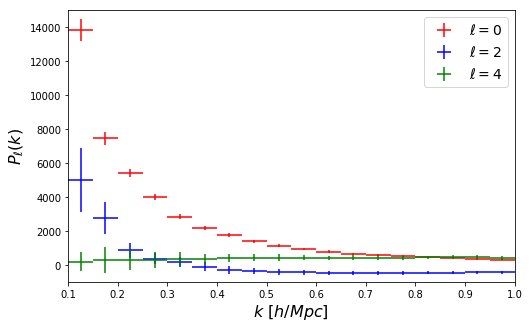

In [432]:
plt.figure(figsize=(8,5))
plt.errorbar(k_bins,power[:,0],qpm_std[:,0]*10,0.025,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1],qpm_std[:,1]*10,0.025,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2],qpm_std[:,2]*10,0.025,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
print('Using 10x errors')

Using 10x errors


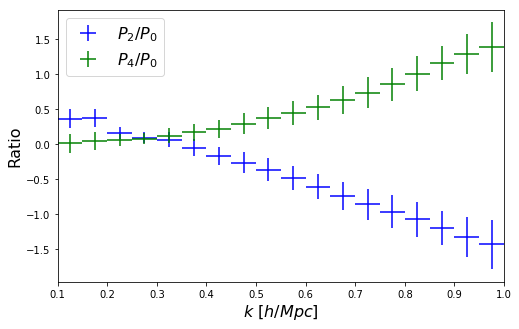

In [433]:
plt.figure(figsize=(8,5))
quad_ratio = power[:,1]/power[:,0]
hex_ratio = power[:,2]/power[:,0]
quad_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
hex_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
plt.errorbar(k_bins,quad_ratio,quad_err*10,0.025,marker='',ls='',c='b',label=r'$P_2/P_0$')
plt.errorbar(k_bins,hex_ratio,10*hex_err,0.025,marker='',ls='',c='g',label=r'$P_4/P_0$')
plt.ylabel(r'Ratio',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
#plt.yscale('log')
plt.legend(fontsize=16);
print("Using 10x errors")

10x Errors for l=0 only here


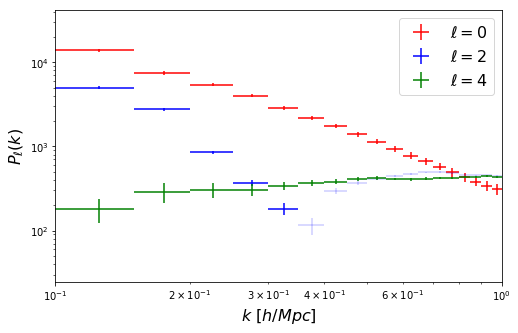

In [434]:
plt.figure(figsize=(8,5))
plt.errorbar(k_bins,power[:,0],qpm_std[:,0]*10,0.025,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1],qpm_std[:,1]*1,0.025,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,-power[:,1],qpm_std[:,1]*1,0.025,marker='',ls='',c='b',alpha=0.2)
plt.errorbar(k_bins,power[:,2],qpm_std[:,2]*1,0.025,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16);
print("10x Errors for l=0 only here")

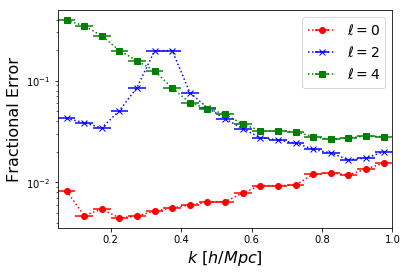

In [437]:
x=np.abs(qpm_std/pow_mean)
plt.errorbar(k_bins,x[:,0],None,0.025,c='r',label=r'$\ell = 0$',ls=':',marker='o')
plt.errorbar(k_bins,x[:,1],None,0.025,c='b',label=r'$\ell = 2$',ls=':',marker='x')
plt.errorbar(k_bins,x[:,2],None,0.025,c='g',label=r'$\ell = 4$',ls=':',marker='s')
plt.yscale('log');
plt.xlim([0.05,1.])
plt.legend(fontsize=14);
plt.ylabel('Fractional Error',fontsize=16);
plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16);

### Compare to CAMB Kaiser model

Using 10x errors


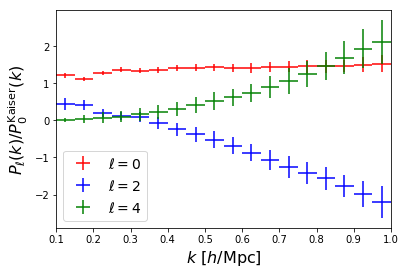

In [443]:
plt.errorbar(k_bins,power[:,0]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,0]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,1]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,2]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)/P_0^\mathrm{Kaiser}(k)$',fontsize=16);
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
plt.legend(fontsize=14);
plt.xlim([0.1,1.])
print("Using 10x errors")

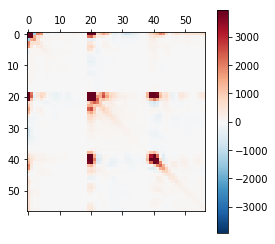

In [445]:
mat=qpm_cov
vmax=np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

In [446]:
gaussian_cov = np.load('gaussian_power_tot.npy')

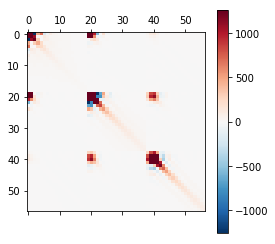

In [448]:
mat=gaussian_cov
vmax=np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

In [269]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl2 = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl2(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # kaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

(0.0, 1.0)

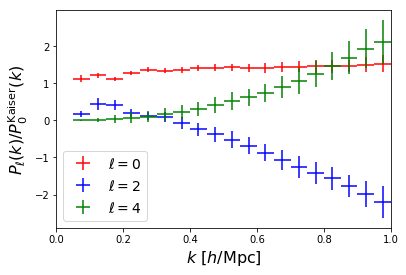

In [317]:
plt.errorbar(k_bins,power[:,0]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,0]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,1]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/kaiser_power_model(k_bins,0),xerr=0.025,
             yerr=pow_std[:,2]/kaiser_power_model(k_bins,0)*10,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)/P_0^\mathrm{Kaiser}(k)$',fontsize=16);
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
plt.legend(fontsize=14);
plt.xlim([0.0,1.])

In [321]:
power_ravel = np.asarray([pp.T.reshape(-1,) for pp in all_power])

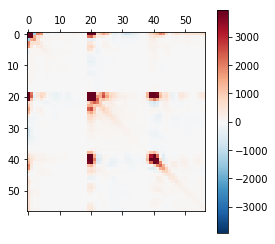

In [322]:
mat=np.cov(power_ravel.T)
vmax=np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

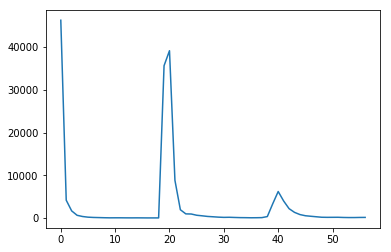

In [119]:
plt.plot(np.diag(mat));#plt.yscale('log');

In [118]:
theory_cov=np.load('theory_power_cov.npy')

In [61]:
plt.matshow(inv_theory);plt.colorbar()

NameError: name 'inv_theory' is not defined

In [803]:
inv_theory = np.linalg.inv(theory_cov)
sq_inv_th = np.linalg.cholesky(inv_theory)
disc = np.matmul(sq_inv_th.T,np.matmul(cov,sq_inv_th))

LinAlgError: Matrix is not positive definite

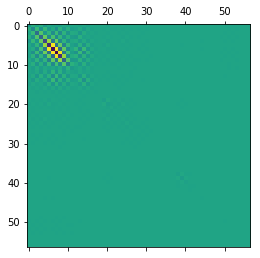

In [801]:
plt.matshow(inv_theory*mat)

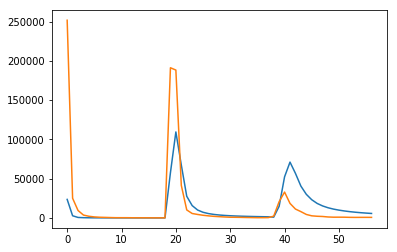

In [798]:
plt.plot(np.diag(theory_cov))
plt.plot(np.diag(mat)*5)

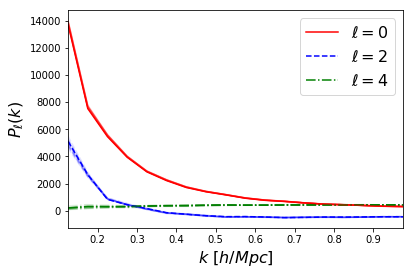

In [105]:
for i in range(n_mocks):
    if i==0:
        plt.plot(k_bins,all_power[i][:,0],label=r'$\ell=0$',c='r',ls='-')
        plt.plot(k_bins,all_power[i][:,1],label=r'$\ell=2$',c='b',ls='--')
        plt.plot(k_bins,all_power[i][:,2],label=r'$\ell=4$',c='g',ls='-.')
    else:
        plt.plot(k_bins,all_power[i][:,0],c='r',ls='-',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,1],c='b',ls='--',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,2],c='g',ls='-.',alpha=0.1)
plt.legend(fontsize=16);
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.125,0.975]);

In [93]:
all_power[0][0]

array([13715.95492505,  5109.8731135 ,   206.8363445 ])

In [26]:
power_estimate = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm

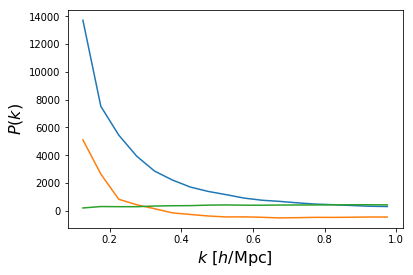

In [285]:
#plt.plot(k_bins,power_estimate)
plt.plot(k_bins,binned_power_estimate.reshape(-1,3))
#plt.yscale('log')
plt.ylabel(r'$P(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/$Mpc]',fontsize=16);

**Add simple CAMB model for comparison**

In [62]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # jaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

In [63]:
from scipy.integrate import quad

ell=0

#binned_power = []
true_binned_power = []
true_point_power = []

for i in range(len(all_k)):
    #binned_power.append(quad(lambda k: kaiser_power_model(k,2)*k,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k,k_bins[i,0],k_bins[i,1])[0])
    true_binned_power.append(quad(lambda k: kaiser_power_model(k,0)*k**2.,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k**2.,all_k[i,0],all_k[i,1])[0])
    true_point_power.append(kaiser_power_model(np.mean([all_k[i,0],all_k[i,1]]),0))

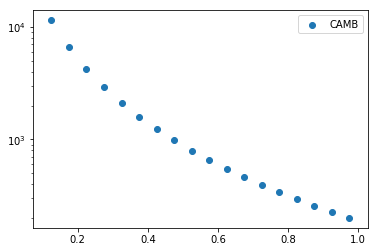

In [72]:
kk = np.mean(all_k,axis=1)
plt.scatter(kk,power_estimate,label='RascalC')
plt.scatter(kk,true_point_power,label='CAMB');
plt.legend();plt.yscale('log');

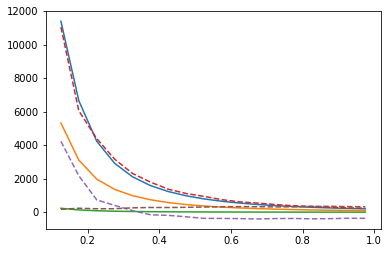

In [78]:
for ell in [0,2,4]:
    plt.plot(kk,[kaiser_power_model(k,ell) for k in kk])
plt.plot(kk,power_estimate.reshape(-1,3)*0.8,ls='--')

#### Compare binned vs unbinned

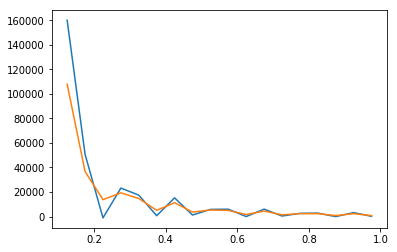

In [105]:
plt.plot(k_bins,DD)
plt.plot(k_bins,DD_binned)

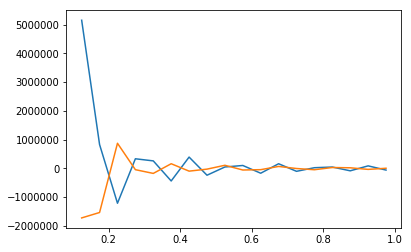

In [107]:
plt.plot(k_bins,DR)
plt.plot(k_bins,DR_binned)